In [2]:
import pandas as pd
import os.path
import warnings
warnings.filterwarnings( 'ignore' )

data = pd.read_csv(os.getcwd() + '/steam_games.csv')
print(len(data))


40750


In [3]:
# Remove all invalid games, non english games, and non games
data = data[data['name'].str.contains('', na=False)] 
data = data[data['types'].str.contains('app')]
data = data[data['languages'].str.contains('English', na=False)]

# Replace all null genres and tags with 'Other'
data['genre'] = data['genre'].fillna('Other')
data['genre'] = data['genre'].str.replace(',', ', ')
data['popular_tags'] = data['popular_tags'].fillna('Other')
data['popular_tags'] = data['popular_tags'].str.replace(',', ', ')
data['game_details'] = data['game_details'].fillna('Other')

# Replace all no review games with 'Mixed'
data['all_reviews'] = data['all_reviews'].fillna('Mixed')

# Change reviews from strings to numerical values
def check_tuple(tuple_value):
    if 'overwhelmingly positive' in tuple_value.lower():
        return 4
    elif 'very positive' in tuple_value.lower():
        return 3
    elif 'mostly positive' in tuple_value.lower():
        return 1
    elif 'mixed' in tuple_value.lower():
        return 0
    elif 'overwhelmingly negative' in tuple_value.lower():
        return -4
    elif 'very negative' in tuple_value.lower():
        return -3
    elif 'mostly negative' in tuple_value.lower():
        return -1
    elif 'negative' in tuple_value.lower():
        return -2
    elif 'positive' in tuple_value.lower():
        return 2
    else:
        return 0
      
def check_tuple2(tuple_value):
    if 'overwhelmingly positive' in tuple_value.lower():
        return 'Overwhelmingly Positive'
    elif 'very positive' in tuple_value.lower():
        return 'Very Positive'
    elif 'mostly positive' in tuple_value.lower():
        return 'Mostly Positive'
    elif 'mixed' in tuple_value.lower():
        return 'Mixed'
    elif 'overwhelmingly negative' in tuple_value.lower():
        return 'Overwhelmingly Negative'
    elif 'very negative' in tuple_value.lower():
        return 'Very Negative'
    elif 'mostly negative' in tuple_value.lower():
        return 'Mostly Negative'
    elif 'negative' in tuple_value.lower():
        return 'Negative'
    elif 'positive' in tuple_value.lower():
        return 'Positive'
    else:
        return 'No Data'
      
data['review_scores'] = data['all_reviews']
data['review_scores'] = data['review_scores'].apply(check_tuple)
data['all_reviews'] = data['all_reviews'].apply(check_tuple2)

# Remove 12 irrelevant features to the training set 
data.drop(['url', 'types', 'recent_reviews', 'achievements', 'original_price', 'recommended_requirements', 'discount_price', 'minimum_requirements', 'mature_content', 'game_description',
           'release_date', 'languages'], axis=1, inplace=True)

col_list = data.columns.tolist()

#Clean rest and special characters icons
for i in col_list:
  data[i] = data[i].fillna('')
  if isinstance(data[i], str):
  	data[i] = data[i].str.replace('[^\w\s]','')
  # else:
  	# data[i] = data[i].astype(str).lower()
  	# data[i] = data[i].astype(str).replace('[^\w\s]','')	

print(len(data))
list(data.columns)

38003


['name',
 'desc_snippet',
 'all_reviews',
 'developer',
 'publisher',
 'popular_tags',
 'game_details',
 'genre',
 'review_scores']

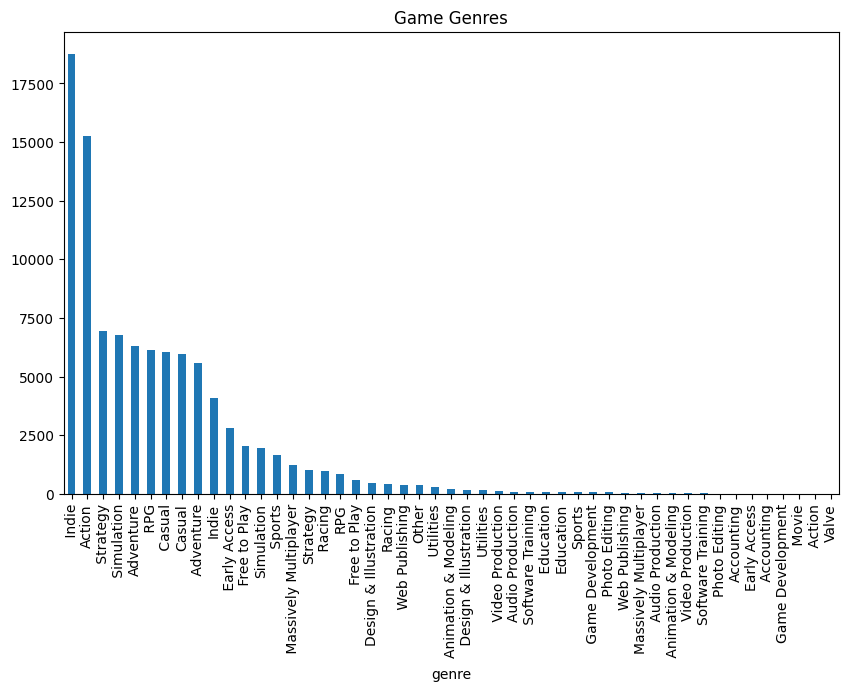

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

map_df = data.copy()

map_df['genre'] = map_df['genre'].str.split(',')
data_exploded = map_df.explode('genre')
counts = data_exploded['genre'].value_counts()

# Create a pie chart
ax = counts.plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Game Genres')
plt.show()

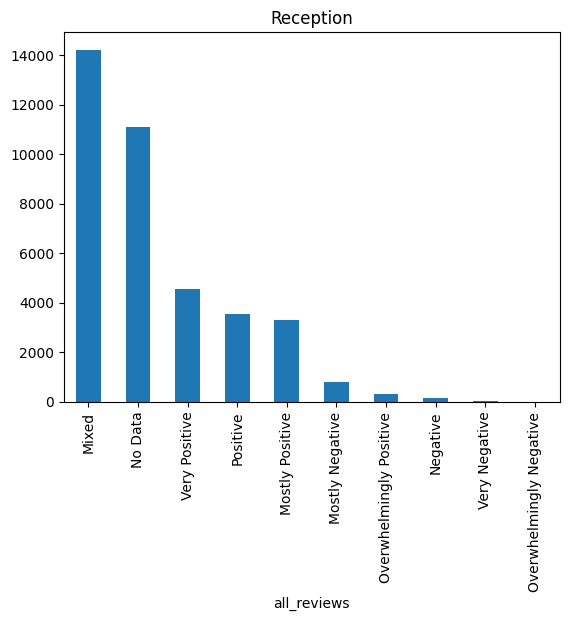

In [5]:
# Create a pie chart
ax = data['all_reviews'].value_counts().plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Reception')
plt.show()

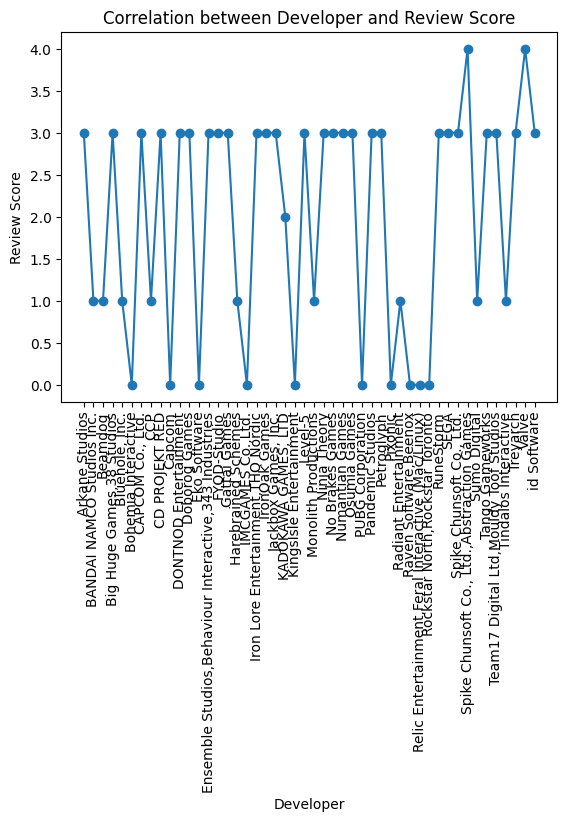

<Figure size 1000x600 with 0 Axes>

In [6]:
gf = data.head(50)
grouped_df = gf[['developer', 'review_scores']].groupby('developer').mean()

plt.plot(grouped_df.index, grouped_df['review_scores'], marker='o')
plt.xlabel('Developer')
plt.xticks(rotation = 90)
plt.ylabel('Review Score')
plt.title('Correlation between Developer and Review Score')
plt.figure(figsize=(10,6))

plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from IPython.display import display

df = data.head(20000)
# df = data.copy()

df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.replace('[^\w\s]','')

# select a game to use as input
input_game = 'doom' #try 'doom' too

indices = pd.Series(df.index, index=df['name'])
idx = indices[input_game.lower()]

# feature extraction
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
# df['features'] = df.apply(lambda x: ' '.join([x['name'], x['developer'], x['publisher'], x['popular_tags'], x['genre']]), axis=1)
df['features'] = df.apply(lambda x: ' '.join([x['name'], x['desc_snippet'], x['popular_tags'], x['genre']]), axis=1)

tfidf_matrix = tfidf.fit_transform(df['features'])

# build the model
cosine_similarities = linear_kernel(tfidf_matrix)

# # evaluate the model
sim_scores = list(enumerate(cosine_similarities[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:11]
game_indices = [i[0] for i in sim_scores]
recommendations = data.iloc[game_indices]

# create a new dataframe with the recommended games and their similarity scores
output_df = pd.DataFrame(columns=['name', 'similarity_score', 'developer', 'popular_tags', 'genre'])
output_df['name'] = recommendations['name']
output_df['similarity_score'] = [i[1] for i in sim_scores]
output_df['developer'] = recommendations['developer']
output_df['publisher'] = recommendations['publisher']
output_df['popular_tags'] = recommendations['popular_tags']
output_df['genre'] = recommendations['genre']

# print the table of recommendations
print("Recommendations for", input_game)
print("---------------------------")
display(output_df)

Recommendations for doom
---------------------------


,name,similarity_score,developer,popular_tags,genre,publisher
217,Killing Floor 2,0.094818,Tripwire Interactive,"Zombies, Co-op, Gore, FPS, Survival, Multiplay...",Action,"Tripwire Interactive,Tripwire Interactive"
2101,DOOM 3 Resurrection of Evil,0.090278,id Software,"Action, FPS, Horror, Sci-fi, Dark, Atmospheric...",Action,"id Software,id Software"
1340,Quake IV,0.088629,RavenSoft / id Software,"FPS, Action, Shooter, Sci-fi, Horror, Singlepl...",Action,"Bethesda Softworks,Bethesda Softworks"
837,Doom 3: BFG Edition,0.086276,id Software,"FPS, Horror, Action, Shooter, Classic, Sci-fi,...",Action,"Bethesda Softworks,Bethesda Softworks"
1401,System Shock 2,0.083768,"Irrational Games,Looking Glass Studios","Cyberpunk, RPG, Sci-fi, Horror, Classic, FPS, ...","Action, RPG","Nightdive Studios,Nightdive Studios"
1292,Painkiller Hell & Damnation,0.082371,The Farm 51,"Action, FPS, Gore, Co-op, Horror, Singleplayer...",Action,"THQ Nordic,THQ Nordic"
1761,Black Squad,0.081655,NS STUDIO,"Early Access, Free to Play, FPS, Shooter, Mult...","Action, Free to Play, Early Access","NS STUDIO,NS STUDIO"
8911,PAYDAY 2: Sydney Character Pack,0.080031,OVERKILL - a Starbreeze Studio.,"Action, RPG, FPS, Co-op, Memes","Action, RPG",
365,DOOM Eternal,0.078959,id Software,"Gore, Violent, Action, FPS, Great Soundtrack, ...",Action,"Bethesda Softworks,Bethesda Softworks"
13817,Putrefaction 2: Void Walker,0.077930,Kazakov Oleg,"Gore, Action, Indie, Violent, FPS, Horror, Sho...","Action, Indie","Kazakov Oleg,Kazakov Oleg"
